In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import seaborn as sns
#from warnings import filterwarnings
#filterwarnings('ignore')

Analysis per Tier:

-	Number of active SP
-	Number of average orders per year
-	Average Basket Value
-	Frequency
-	Average Sales
-	CM1 
-	CM2
-	Share of Proplan Sales per Tier
-	Share of Orders with Proplan per Tier
-	Repurchasing rate within specific time period per Tier

#### Data loading and processing

In [2]:
data = pd.read_csv('fr_sp_tiers_4_5_orders_jul17_jun18.dsv', sep=';', low_memory=False)

In [3]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_SALES_CANCEL_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,...,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE,PP_ID,PG_ID,PG4_PARENT_ID,PG3_PARENT_ID,PP_NAME,AP_SHORT_TEXT
0,393697838,92204880,08/08/2017 00:00,19:00,4,8181197,"12,99",0,"3,295","-1,4687",...,26/04/2019 23:59,52,3,"5,9",48683.0,2365.0,311.0,251.0,Pedigree Adult Mini Huhn & Gemüse,"- 1,4 kg"
1,393697839,92204880,08/08/2017 00:00,19:00,4,8181197,"4,99",0,"1,6483","0,0604",...,26/04/2019 23:59,52,3,"5,9",48683.0,2365.0,311.0,251.0,Pedigree Adult Mini Huhn & Gemüse,"- 1,4 kg"
2,394339208,92362301,11/08/2017 00:00,13:35,4,11978344,"52,99",0,"11,6183","2,9754",...,01/09/2019 23:59,54,7,"9,99",50871.0,2365.0,311.0,251.0,Pedigree Adult mit Rind & Gemüse,- 15 kg
3,395009419,92524247,14/08/2017 00:00,19:55,4,10724090,"52,99",0,"11,6183","2,9754",...,06/04/2020 23:59,52,3,"5,99",50871.0,2365.0,311.0,251.0,Pedigree Adult mit Rind & Gemüse,- 15 kg
4,395605996,92670163,17/08/2017 00:00,11:22,4,13056972,"52,99",0,"11,6183","2,5565",...,02/06/2020 23:59,52,3,"5,99",50871.0,2365.0,311.0,251.0,Pedigree Adult mit Rind & Gemüse,- 15 kg


In [4]:
def get_date(x):
    return x.split(' ')[0]

In [5]:
data['TDT_T_KEY_ORDER_DATE'] = data['TDT_T_KEY_ORDER_DATE'].map(get_date)

In [6]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446561 entries, 0 to 4446560
Data columns (total 35 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            object
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   object
SCM_SALES_CANCEL_BMF            object
SCM_D_FINANCE_CM1               object
SCM_D_FINANCE_CM2               object
SCM_D_ORIG_FINANCE_ORDER_NET    object
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
SCM_D_QUANTITY                  object
SCM_IS_ZSP_ORDER                int64
SCM_C_ORDER_STATUS              object
CTP_N_KEY_CUSTOMER_TYPE         int64
SCM_OCI_LAND                    object
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              int64
OSP_3_LEAD_P_PG_SHARE           object
OSP_4_LEAD_P_PG_ID              int64
OS

In [7]:
%run -i cleaning_n_formatting.py

Duplicated rows detected:  74979
Start dropping..
Number of order IDs having more than one SP_START_DATE now:  0


In [8]:
data['CZP_ZTQ_ID'].unique()

array([52, 54, 51, 53], dtype=int64)

In [9]:
#Not equal to 0 means the value being cancelled
data['POS_VALID'] = (data['SCM_SALES_CANCEL_BMF'] == 0) * 1 

In [10]:
data[data['POS_VALID'] == 0][['SCM_SALES_BMF', 'SCM_SALES_CANCEL_BMF', 'SCM_D_ORIG_FINANCE_ORDER_NET']].sample(10)

,SCM_SALES_BMF,SCM_SALES_CANCEL_BMF,SCM_D_ORIG_FINANCE_ORDER_NET
242448,62.9900,52.4900,52.4917
676597,49.9900,41.3100,41.3140
4272195,23.9900,19.9900,19.9917
3979538,6.9900,5.8300,5.8250
2474236,19.9800,16.6500,16.6500
873259,13.1062,10.9244,10.9218
2486564,6.2544,5.2131,5.2120
60567,7.9900,6.6600,6.6583
336338,69.9900,58.3300,58.3250
900644,3.9900,3.3300,3.3250


In [11]:
data['TAXES'] = data['SCM_SALES_BMF'] / data['SCM_D_ORIG_FINANCE_ORDER_NET']

In [12]:
data['BASKET_VALUE'] = (data['SCM_SALES_BMF'] * data['POS_VALID']).groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [13]:
data['O_POS_SHARE'] = (data['SCM_SALES_BMF'] * data['POS_VALID']) / data['BASKET_VALUE']

In [14]:
pg4share = [float(str(i).replace(',','.')) for i in data['OSP_4_LEAD_P_PG_SHARE'].values]
data['OSP_4_LEAD_P_PG_SHARE'] = pg4share

#### Number of active SP - customers having placed at least 1 order in the last year -

In [15]:
data['CUS_N_KEY_CUSTOMER'].nunique()

161937

In [16]:
cus_per_tier = data.groupby('CZP_ZTQ_ID')['CUS_N_KEY_CUSTOMER'].nunique()
cus_per_tier

CZP_ZTQ_ID
51    62716
52    46265
53    33402
54    27777
Name: CUS_N_KEY_CUSTOMER, dtype: int64

In [17]:
# 133 customers transitioning between Tiers
data.groupby('CZP_ZTQ_ID')['CUS_N_KEY_CUSTOMER'].nunique().sum()

170160

In [18]:
mask = [len(i) > 1 for i in data.groupby('CUS_N_KEY_CUSTOMER')['CZP_ZTQ_ID'].unique().values]

In [19]:
#Customer IDs belonging to 2 different tiers along time in our data
data.groupby('CUS_N_KEY_CUSTOMER')['CZP_ZTQ_ID'].unique()[mask].index.values

array([  341739,   429938,   451111, ..., 19364850, 19679446, 19757280],
      dtype=int64)

In [20]:
# Get for those customers the old tier
old_tiers_list = []

for i in data.groupby('CUS_N_KEY_CUSTOMER')['CZP_ZTQ_ID'].unique()[mask].index.values:
    c_data = data[data['CUS_N_KEY_CUSTOMER'] == i]
    min_date = c_data['TDT_T_KEY_ORDER_DATE'].min()
    c_tier_min_date = c_data[c_data['TDT_T_KEY_ORDER_DATE'] == min_date]['CZP_ZTQ_ID'].unique()[0]
    old_tiers_list.append(c_tier_min_date)

In [21]:
# Group them by value and sort them
c = Counter(old_tiers_list)
cs = sorted(c.most_common(), key=lambda x: x[0])
cs

[(51, 4080), (52, 1009), (53, 2336), (54, 795)]

In [22]:
# Get the amount of each type -second value of each tuple- and substract them from the previous 
# calculation in line 16 including the same customer in 2 tiers
cs_values = [i[1] for i in cs]
cs_values

[4080, 1009, 2336, 795]

In [23]:
cus_per_tier.values

array([62716, 46265, 33402, 27777], dtype=int64)

In [24]:
cus_per_tier_new_values = cus_per_tier.values - cs_values
cus_per_tier_new_values

array([58636, 45256, 31066, 26982], dtype=int64)

In [25]:
cus_per_tier.index.values

array([51, 52, 53, 54], dtype=int64)

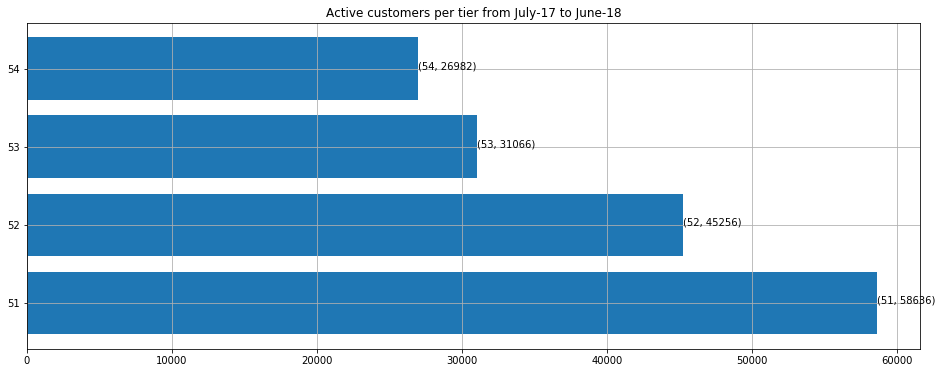

In [26]:
plt.figure(figsize=(16, 6))
plt.barh(cus_per_tier.index.values, cus_per_tier_new_values)
plt.yticks(cus_per_tier.index.values)
plt.title('Active customers per tier from July-17 to June-18')
ax = plt.gca()
for i, txt in enumerate(zip(cus_per_tier.index.values, cus_per_tier_new_values)):
    ax.annotate(txt, (cus_per_tier_new_values[i], cus_per_tier.index.values[i]))
plt.grid()

#### Number of average orders per year (mid 2017 - mid 2018)

In [27]:
data.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].nunique()

CZP_ZTQ_ID
51    303170
52    250040
53    165384
54    156479
Name: SCM_N_ORDER_NR, dtype: int64

In [28]:
tiers = [51, 52, 53, 54]

In [29]:
orders_per_week = data.groupby('WEEK_NUMBER')['SCM_N_ORDER_NR'].nunique()
#New mapping in order to have correlative week numbers
new_week_mapping = {}

In [30]:
for x, y in zip(list(orders_per_week[25:].index.values) + list(orders_per_week[:25].index.values), list(range(1,len(orders_per_week.index.values) + 1))):
    new_week_mapping[x] = y 

In [31]:
week_mapping = [new_week_mapping[i] for i in data['WEEK_NUMBER'].values]
#New column with the new week mapping
data['WEEK_NUMBER_ORDERED'] = week_mapping

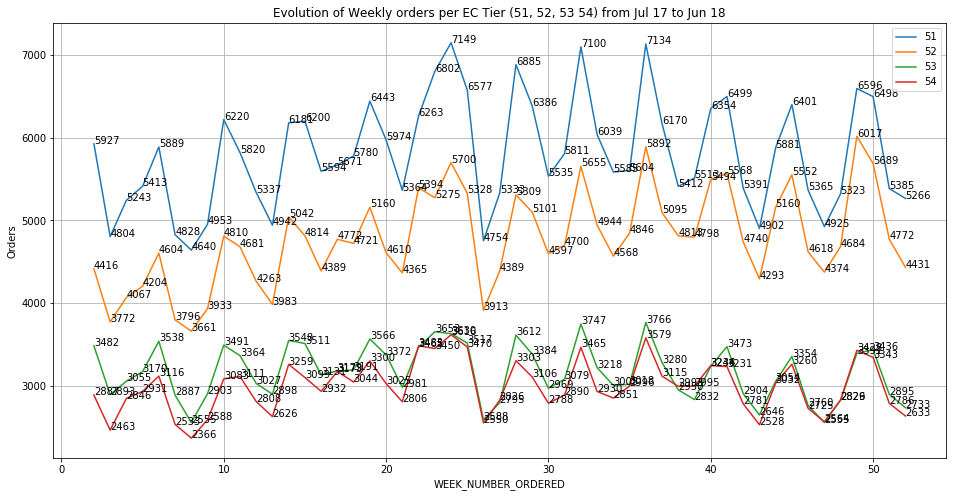

In [32]:
plt.figure(figsize=(16, 8))
for i in tiers:
    tier_data = data[data['CZP_ZTQ_ID'] == i]
    weekly_data = tier_data.groupby('WEEK_NUMBER_ORDERED')['SCM_N_ORDER_NR'].nunique()[1:] #exclude 1st week (week 26 overlapping)
    weekly_data.plot()
    ax = plt.gca()
    for i, txt in enumerate(weekly_data):
        ax.annotate(txt, (weekly_data.index[i], weekly_data.values[i]))
plt.grid(True)
plt.ylabel('Orders')
plt.title('Evolution of Weekly orders per EC Tier (51, 52, 53 54) from Jul 17 to Jun 18')
plt.legend(tiers) 
plt.show()

#### Average Basket Value

In [33]:
order_values_per_tier = data.groupby(['CZP_ZTQ_ID', 'SCM_N_ORDER_NR'], as_index=False)['BASKET_VALUE'].mean()

In [34]:
order_values_per_tier.sample(5)

,CZP_ZTQ_ID,SCM_N_ORDER_NR,BASKET_VALUE
263813,51,110608105,74.67
585250,53,94122178,76.44
114092,51,98813320,71.35
806465,54,103068943,42.24
727508,54,91220249,199.72


In [35]:
order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
CZP_ZTQ_ID,,,,,,,,
51,303170.0,75.84,44.61,-41.05,46.66,63.51,93.69,1058.01
52,250040.0,86.67,55.11,-68.24,50.38,72.73,106.67,1962.27
53,165384.0,79.91,50.34,-50.69,47.49,66.49,97.83,1487.13
54,156479.0,93.19,66.59,-118.55,52.23,78.84,113.01,3546.67


Due to high spreadness of the sample is more robust use the median

#### Average Sales

In [36]:
#12 months sales
order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].sum().round(2)

CZP_ZTQ_ID
51    22992806.16
52    21669984.65
53    13216593.71
54    14581955.25
Name: BASKET_VALUE, dtype: float64

In [37]:
# Monthly average sales
np.round(order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].sum() / 12, 2)

CZP_ZTQ_ID
51    1916067.18
52    1805832.05
53    1101382.81
54    1215162.94
Name: BASKET_VALUE, dtype: float64

In [38]:
# Weekly average sales
np.round(order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].sum() / 52, 2)

CZP_ZTQ_ID
51    442169.35
52    416730.47
53    254165.26
54    280422.22
Name: BASKET_VALUE, dtype: float64

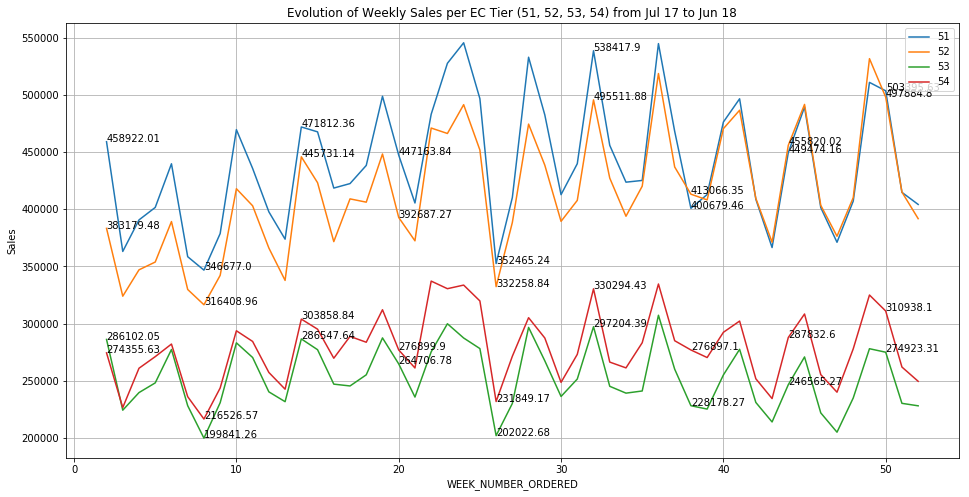

In [39]:
plt.figure(figsize=(16, 8))
for i in tiers:
    tier_data = data[data['CZP_ZTQ_ID'] == i]
    week_sales_tier = tier_data.groupby(['WEEK_NUMBER_ORDERED', 'SCM_N_ORDER_NR'], as_index=False)['BASKET_VALUE'].mean()
    weekly_data = week_sales_tier.groupby('WEEK_NUMBER_ORDERED')['BASKET_VALUE'].sum()[1:] #exclude 1st week (week 26 overlapping)
    weekly_data.plot()
    ax = plt.gca()
    for i, txt in enumerate(weekly_data):
        if i % 6 == 0:
            ax.annotate(np.round(txt, 2), (weekly_data.index[i], weekly_data.values[i]))
plt.grid(True)
plt.ylabel('Sales')
plt.title('Evolution of Weekly Sales per EC Tier (51, 52, 53, 54) from Jul 17 to Jun 18')
plt.legend(tiers) 
plt.show()

#### CM1 

In [40]:
data['ORDER_CM1'] = (data['SCM_D_FINANCE_CM1'] * data['POS_VALID']).groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [41]:
data['ORDER_NET_SALES'] = (data['SCM_D_ORIG_FINANCE_ORDER_NET'] * data['POS_VALID']).groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [42]:
data['ORDER_CM1%'] = data['ORDER_CM1'] / data['ORDER_NET_SALES'] * 100

In [43]:
data['ORDER_CM2'] = (data['SCM_D_FINANCE_CM2'] * data['POS_VALID']).groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [44]:
data['ORDER_CM2%'] = data['ORDER_CM2'] / data['ORDER_NET_SALES'] * 100

In [45]:
cm_values_per_tier = data.groupby(['CZP_ZTQ_ID', 'SCM_N_ORDER_NR'], as_index=False)[['ORDER_NET_SALES', 'ORDER_CM1', 
                                                                                     'ORDER_CM1%', 'ORDER_CM2',
                                                                                     'ORDER_CM2%']].mean()

In [46]:
cm_values_per_tier.sample(5).round(2)

,CZP_ZTQ_ID,SCM_N_ORDER_NR,ORDER_NET_SALES,ORDER_CM1,ORDER_CM1%,ORDER_CM2,ORDER_CM2%
333096,52,92858497,41.21,10.84,26.30,3.10,7.52
522947,52,111071510,64.47,35.60,55.22,27.60,42.80
390550,52,98505658,56.58,11.14,19.70,2.42,4.28
616273,53,98459999,39.57,6.43,16.23,-1.33,-3.35
706727,53,112015532,72.82,22.04,30.26,6.36,8.73


In [47]:
# CM1 per tier
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM1'].sum().round(2)

CZP_ZTQ_ID
51    5587472.51
52    5125938.87
53    3236391.73
54    3274337.67
Name: ORDER_CM1, dtype: float64

In [48]:
# CM1 per order in each tier
(cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM1'].sum() /\
cm_values_per_tier.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].count()).round(2)

CZP_ZTQ_ID
51    18.43
52    20.50
53    19.57
54    20.93
dtype: float64

In [49]:
# CM1% per tier
(cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM1'].sum() /\
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_NET_SALES'].sum() * 100).round(2)

CZP_ZTQ_ID
51    29.14
52    28.36
53    29.32
54    26.89
dtype: float64

In [50]:
cm_values_per_tier[cm_values_per_tier['ORDER_CM1%'] == cm_values_per_tier['ORDER_CM1%'].min()]

,CZP_ZTQ_ID,SCM_N_ORDER_NR,ORDER_NET_SALES,ORDER_CM1,ORDER_CM1%,ORDER_CM2,ORDER_CM2%
96219,51,97395020,0.0,-0.80,-inf,-5.6396,-inf
146826,51,101345375,0.0,-29.13,-inf,-38.3738,-inf
359982,52,95506367,0.0,-1.73,-inf,-6.5112,-inf
497708,52,108697337,0.0,-1.76,-inf,-8.1606,-inf
519593,52,110717915,0.0,-0.46,-inf,-0.8845,-inf
643816,53,102425743,0.0,-0.84,-inf,-8.9222,-inf


In [51]:
cm_values_per_tier['ORDER_CM1%'].iloc[440895] = 0

C:\Users\albertoma\AppData\Local\conda\conda\envs\py36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
cm_values_per_tier['ORDER_CM1%'] = cm_values_per_tier['ORDER_CM1%'].replace(-np.inf, 0).fillna(0).astype(float)

In [53]:
type(cm_values_per_tier['ORDER_CM1%'][0])

numpy.float64

In [54]:
# CM1% per order in each tier
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM1%'].mean().round(2)

CZP_ZTQ_ID
51    30.81
52    30.11
53    30.93
54    28.46
Name: ORDER_CM1%, dtype: float64

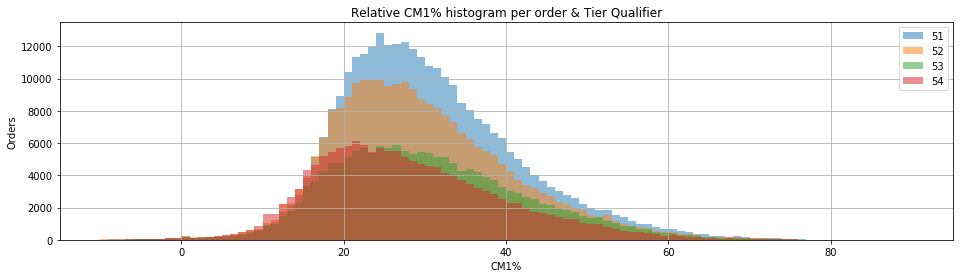

,Tier 51,Tier 52,Tier 53,Tier 54
count,303170.00,250040.00,165384.00,156479.00
mean,30.81,30.11,30.93,28.46
std,58.33,23.36,38.26,31.49
min,-28951.77,-5750.69,-4288.69,-8461.60
25%,22.85,21.83,21.94,19.73
50%,29.06,28.20,29.31,26.57
75%,37.00,36.32,38.09,35.32
max,2393.85,5986.00,11548.04,2405.75


In [55]:
concat_df = pd.DataFrame()

plt.figure(figsize=(16,4))
plt.title('Relative CM1% histogram per order & Tier Qualifier')
plt.xlabel('CM1%')
plt.ylabel('Orders')

for i in tiers:
    tier_data = cm_values_per_tier[cm_values_per_tier['CZP_ZTQ_ID'] == i]
    tier_data['ORDER_CM1%'].hist(bins=100, range=(-10, 90), alpha=0.5)
    plt.legend(tiers)
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(tier_data['ORDER_CM1%'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51', 'Tier 52', 'Tier 53', 'Tier 54']
display(concat_df)

#### CM2

In [56]:
# CM2 per tier
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM2'].sum().round(2)

CZP_ZTQ_ID
51    2461534.33
52    2258420.56
53    1466427.64
54    1384881.21
Name: ORDER_CM2, dtype: float64

In [57]:
# CM2 per order in each tier
(cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM2'].sum() /\
cm_values_per_tier.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].count()).round(2)

CZP_ZTQ_ID
51    8.12
52    9.03
53    8.87
54    8.85
dtype: float64

In [58]:
# CM2% per tier
(cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM2'].sum() /\
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_NET_SALES'].sum() * 100).round(2)

CZP_ZTQ_ID
51    12.84
52    12.49
53    13.29
54    11.37
dtype: float64

In [59]:
cm_values_per_tier[cm_values_per_tier['ORDER_CM2%'] == cm_values_per_tier['ORDER_CM2%'].min()]

,CZP_ZTQ_ID,SCM_N_ORDER_NR,ORDER_NET_SALES,ORDER_CM1,ORDER_CM1%,ORDER_CM2,ORDER_CM2%
96219,51,97395020,0.0,-0.80,0.0,-5.6396,-inf
146826,51,101345375,0.0,-29.13,0.0,-38.3738,-inf
359982,52,95506367,0.0,-1.73,0.0,-6.5112,-inf
497708,52,108697337,0.0,-1.76,0.0,-8.1606,-inf
519593,52,110717915,0.0,-0.46,0.0,-0.8845,-inf
643816,53,102425743,0.0,-0.84,0.0,-8.9222,-inf


In [60]:
cm_values_per_tier['ORDER_CM2%'] = cm_values_per_tier['ORDER_CM2%'].replace(-np.inf, 0).fillna(0).astype(float)

In [61]:
cm_values_per_tier['ORDER_CM2%'].iloc[440895] = 0

C:\Users\albertoma\AppData\Local\conda\conda\envs\py36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [62]:
# CM2% per order in each tier
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM2%'].mean().round(2)

CZP_ZTQ_ID
51    12.25
52    12.07
53    12.56
54    10.73
Name: ORDER_CM2%, dtype: float64

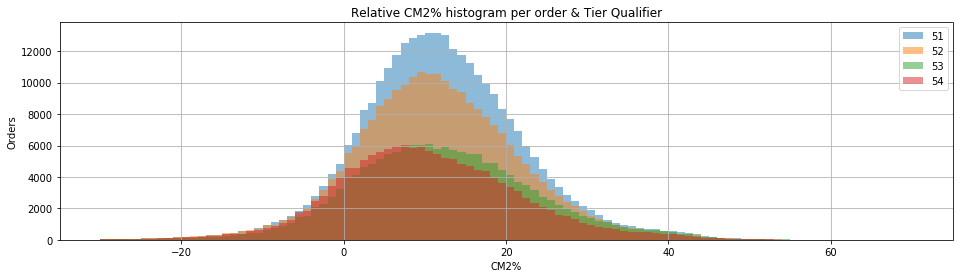

,Tier 51,Tier 52,Tier 53,Tier 54
count,303170.00,250040.00,165384.00,156479.00
mean,12.25,12.07,12.56,10.73
std,77.94,30.85,49.15,49.13
min,-38377.77,-6722.55,-6444.44,-12659.76
25%,5.58,4.99,4.70,3.02
50%,11.60,11.23,11.78,9.78
75%,18.21,18.08,19.50,17.54
max,9999.55,7448.48,13530.04,7740.58


In [151]:
concat_df = pd.DataFrame()

plt.figure(figsize=(16,4))
plt.title('Relative CM2% histogram per order & Tier Qualifier')
plt.xlabel('CM2%')
plt.ylabel('Orders')

for i in tiers:
    tier_data = cm_values_per_tier[cm_values_per_tier['CZP_ZTQ_ID'] == i]
    tier_data['ORDER_CM2%'].hist(bins=100, range=(-30, 70), alpha=0.5)
    plt.legend(tiers)
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(tier_data['ORDER_CM2%'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51', 'Tier 52', 'Tier 53', 'Tier 54']
display(concat_df)

#### Share of Proplan Sales per Tier

Let's get the physical articles belonging to PG4 groups: 283, 286, 192127.

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
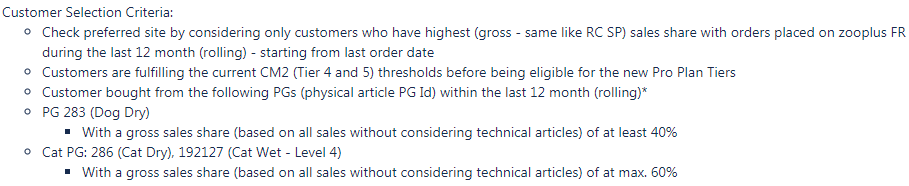

In [64]:
query = """select *
from zoocube.DDSTD_PPR_PHYS_PRODUCT
where PPR_N_LEVEL4_ID in (283, 286, 192127)"""

In [65]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
curs = conn.cursor()
pg4ids = pd.read_sql(query, con = conn)
conn.close()

In [66]:
pg4ids

,PPR_N_KEY_PHYS_PRODUCT,PPR_N_PHY_PRODUCT_ID,PPR_N_PHY_ARTICLE_ID,PPR_V_PRODUCT_DESC,PPR_V_LOGISTICS_DESC,PPR_N_LEVEL1_ID,PPR_V_LEVEL1_DESC,PPR_N_LEVEL2_ID,PPR_V_LEVEL2_DESC,PPR_N_LEVEL3_ID,...,PPR_IS_HIGH_CLV,PPR_BRAND,PPR_PG_PRIORITY,PPR_EAN,PPR_NR_AT_SUPPLIER,PPR_AP_IS_LISTED,PPR_ARTICLE_CLASS_ID,PPR_ART_CLASS_DESC,PPR_TAX_CODE,PPR_APA_DESC
0,5771,2159,3296,2159 - Pro Plan Dog Adult Dog Huhn + Reis,3296 - Pro Plan Dog Adult Dog - 15 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000583,5100138,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
1,5772,2159,3295,2159 - Pro Plan Dog Adult Dog Huhn + Reis,3295 - Pro Plan Dog Adult Dog H- 3 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,7613033208263,12150307,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
2,5773,2160,1495,2160 - Pro Plan Dog Performance Huhn,1495 - Pro Plan Dog Performanc- 800 g,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000-651,1023300,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
3,5775,2160,3418,2160 - Pro Plan Dog Performance Huhn,3418 - Pro Plan Dog Performanc- 15 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000682,05100158,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
4,5776,2160,3416,2160 - Pro Plan Dog Performance Huhn,3416 - Pro Plan Dog Performance- 3 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,8410650530306,8473000,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
5,5777,2161,1500,2161 - Pro Plan Dog Adult Light Huhn,1500 - Pro Plan Dog Adult Ligh- 800 g,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000-705,8143000,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
6,5778,2161,11891,2161 - Pro Plan Dog Adult Light Huhn,11891 - Pro Plan Dog Adult Light- 3 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,07613033209994,12150387,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
7,5779,2161,3420,2161 - Pro Plan Dog Adult Light Huhn,3420 - Pro Plan Dog Adult Ligh- 15 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000736,5100163,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
8,5780,2161,3419,2161 - Pro Plan Dog Adult Light Huhn,"3419 - Pro Plan Dog Adult Lig- 7,5 kg",2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,8410650530758,8454000,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
9,5782,2158,3294,2158 - Pro Plan Dog Puppy Huhn + Reis,"3294 - Pro Plan Dog Puppy Huh- 7,5 kg",2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000439,5119955,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU


In [67]:
proplan_arts = list(set(pg4ids['PPR_N_PHY_ARTICLE_ID']))

In [68]:
proplan_names = list(data[data['SCM_AP_ID'].isin(proplan_arts)]['PP_NAME'].unique())

In [69]:
len(proplan_names)

55

In [70]:
proplan_names

['Pro Plan Medium Adult Sensitive Digestion Huhn & Reis',
 'Pro Plan All sizes Adult Performance Huhn & Reis',
 'Pro Plan Medium Adult Huhn & Reis',
 'Pro Plan Large Adult Robust Huhn & Reis',
 'Pro Plan All sizes Adult Light Sterilised Huhn & Reis',
 'Pro Plan Large Puppy Robust Huhn & Reis',
 'Pro Plan Large Ath. Adult Lamm',
 'Pro Plan Medium & Large Adult 7+ Huhn & Reis',
 'Pro Plan Large Puppy Athletic Huhn & Reis',
 'Pro Plan Medium Puppy Lamm',
 'Pro Plan Medium Puppy Sensitive Skin Lachs & Reis',
 'Pro Plan Medium Adult Lamm',
 'Pro Plan Medium & Large Adult 7+ Sensitive Skin Lachs & Reis',
 'Pro Plan Small & Mini Adult Huhn & Reis',
 'Pro Plan Large Adult Atheltic Huhn & Reis',
 'Pro Plan Medium Adult Sensitive Skin Lachs & Reis',
 'Pro Plan Small & Mini Adult Sensitive Skin Lachs & Reis',
 'Pro Plan Small and Mini Stv Digestion Chicken',
 'Pro Plan Small & Mini Puppy Huhn & Reis',
 'Pro Plan Small & Mini Puppy Sensitive Skin Lachs & Reis',
 'Pro Plan Medium Puppy Sensitive Di

In [71]:
#Let's create a flag for this order positions including ProPlan articles
data['IS_PRO_PLAN_ART'] = (data['SCM_AP_ID'].isin(proplan_arts)) * 1

In [72]:
data[['PP_NAME', 'POS_VALID', 'SCM_SALES_BMF', 'SCM_SALES_CANCEL_BMF', 'IS_PRO_PLAN_ART']].sample(20)

,PP_NAME,POS_VALID,SCM_SALES_BMF,SCM_SALES_CANCEL_BMF,IS_PRO_PLAN_ART
519562,Xmas plush ice bear dog toy,1,3.9900,0.0,0
165120,RAZAS Schinkenknochen,1,9.9900,0.0,0
3944179,Hill's Science Plan Sterilised Cat Young Adult,1,92.9900,0.0,0
953527,Seresto Collier Katze (FR),1,20.9900,0.0,0
784497,Tigeria 7 Snacks,1,0.0000,0.0,0
2505597,Feliway DE,1,16.9900,0.0,0
2824470,Smilla Trockenfutter Adult Sterilised,1,3.9900,0.0,0
3977215,Bozita Häppchen in Gelee 370 g,1,6.9900,0.0,0
962366,Cuni Nature Kaninchenfutter,1,8.9900,0.0,0
1558637,NaN,1,-1.2900,0.0,0


In [73]:
# Get Pro Plan Articles order positions
proplan_o_pos = data[data['IS_PRO_PLAN_ART'] == 1]

In [74]:
pp_o_pos = proplan_o_pos.copy()

In [75]:
pp_o_pos['PP_SALES'] = pp_o_pos['SCM_SALES_BMF'] * pp_o_pos['POS_VALID']

In [76]:
# Quantify ProPlan Articles Sales per Tier Qualifier
proplan_sales_per_tier = pp_o_pos.groupby('CZP_ZTQ_ID')['PP_SALES'].sum().round(2)
proplan_sales_per_tier

CZP_ZTQ_ID
51     890923.17
52    1263273.76
53     624539.50
54    1080932.21
Name: PP_SALES, dtype: float64

In [77]:
# Obtain Sales Per Tier Qualifier
sales_per_tier = order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].sum().round(2)
sales_per_tier

CZP_ZTQ_ID
51    22992806.16
52    21669984.65
53    13216593.71
54    14581955.25
Name: BASKET_VALUE, dtype: float64

**Share of ProPlan Sales per Tier:**

In [78]:
share_s_pp_tier = (proplan_sales_per_tier/sales_per_tier * 100).round(2) 
share_s_pp_tier

CZP_ZTQ_ID
51    3.87
52    5.83
53    4.73
54    7.41
dtype: float64

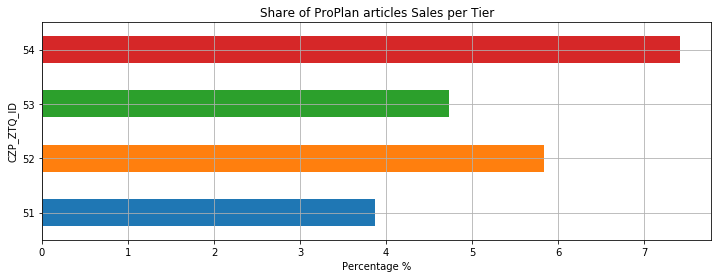

In [79]:
plt.figure(figsize=(12, 4))
share_s_pp_tier.plot(kind='barh')
plt.title('Share of ProPlan articles Sales per Tier')
plt.xlabel('Percentage %')
plt.grid()

#### Share of Orders with Proplan per Tier

In [80]:
# Orders having ProPlan articles per Tier
orders_with_proplan_per_tier = proplan_o_pos.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].nunique()
orders_with_proplan_per_tier

CZP_ZTQ_ID
51    15606
52    18619
53     9969
54    14123
Name: SCM_N_ORDER_NR, dtype: int64

In [81]:
# Total orders per Tier
orders_per_tier = data.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].nunique()
orders_per_tier

CZP_ZTQ_ID
51    303170
52    250040
53    165384
54    156479
Name: SCM_N_ORDER_NR, dtype: int64

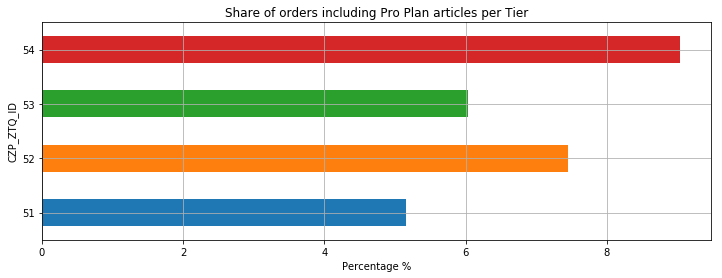

In [82]:
share_o_pp_tier = (orders_with_proplan_per_tier / orders_per_tier * 100).round(2)
plt.figure(figsize=(12, 4))
share_o_pp_tier.plot(kind='barh')
plt.title('Share of orders including Pro Plan articles per Tier')
plt.xlabel('Percentage %')
plt.grid()

In [83]:
# Share of orders with Pro Plan articles per Tier
share_o_pp_tier

CZP_ZTQ_ID
51    5.15
52    7.45
53    6.03
54    9.03
Name: SCM_N_ORDER_NR, dtype: float64

In [84]:
# Share of total orders having ProPlan articles (7%)
(orders_with_proplan_per_tier.sum() / orders_per_tier.sum()).round(2) * 100

0.07

#### Repurchasing rate within specific time period per Tier

In [85]:
data['CUS_N_KEY_CUSTOMER'].nunique()

161937

In [86]:
#Run calculation at a customer level
customers = pd.DataFrame(columns=['CUSTOMER_ID', 'TIER', 'ORDERS', '1ST_O_DATE', '1ST_O_COUNT',
                                  '28D_DATE', 'N_28D', '56D_DATE', 'N_56D', '84D_DATE','N_84D', '180D_DATE','N_180D', 
                                  'SALES', 'NET_SALES', 'BASKET_AVG', 
                                  'CM1', 'CM1_AVG', 'CM1%', 'CM2', 'CM2_AVG', 'CM2%'
                                  ])

for n, cus in enumerate(data['CUS_N_KEY_CUSTOMER'].unique()):
    cus_data = data[data['CUS_N_KEY_CUSTOMER'] == cus]
    tier = cus_data['CZP_ZTQ_ID'].unique()
    orders = cus_data['SCM_N_ORDER_NR'].nunique()
    first_ord_in_ds = cus_data['OSP_KO_COUNT_NET'].min()
    first_order_date = cus_data[cus_data['OSP_KO_COUNT_NET'] == first_ord_in_ds]['TDT_T_KEY_ORDER_DATE'].dt.date.unique()[0]
    rep_date_28 = first_order_date + timedelta(days = 28)
    rep_date_56 = first_order_date + timedelta(days = 56)
    rep_date_84 = first_order_date + timedelta(days = 84)
    rep_date_180 = first_order_date + timedelta(days = 180)
    n_orders_28d = cus_data[cus_data['TDT_T_KEY_ORDER_DATE'].dt.date <= rep_date_28]['OSP_KO_COUNT_NET'].max()
    n_orders_56d = cus_data[cus_data['TDT_T_KEY_ORDER_DATE'].dt.date <= rep_date_56]['OSP_KO_COUNT_NET'].max()
    n_orders_84d = cus_data[cus_data['TDT_T_KEY_ORDER_DATE'].dt.date <= rep_date_84]['OSP_KO_COUNT_NET'].max()
    n_orders_180d = cus_data[cus_data['TDT_T_KEY_ORDER_DATE'].dt.date <= rep_date_180]['OSP_KO_COUNT_NET'].max()
        
    sales = (cus_data['SCM_SALES_BMF'] * cus_data['POS_VALID']).sum()
    net_sales = (cus_data['SCM_D_ORIG_FINANCE_ORDER_NET'] * cus_data['POS_VALID']).sum()
    basket_avg = sales / orders
    cm1 = (cus_data['SCM_D_FINANCE_CM1'] * cus_data['POS_VALID']).sum()
    cm1_avg = cm1 / orders
    cm1_perc = cm1 / net_sales * 100
    cm2 = (cus_data['SCM_D_FINANCE_CM2'] * cus_data['POS_VALID']).sum()
    cm2_avg = cm2 / orders
    cm2_perc = cm2 / net_sales * 100
    
    row_ = [cus, tier, orders, first_order_date, first_ord_in_ds, rep_date_28, n_orders_28d, rep_date_56,
            n_orders_56d, rep_date_84, n_orders_84d, rep_date_180, n_orders_180d,
            sales, net_sales, basket_avg, cm1, cm1_avg, cm1_perc, cm2, cm2_avg, cm2_perc]
    row_ = pd.DataFrame([row_], columns=customers.columns)
    customers = pd.concat([customers, row_], ignore_index=True)
    
    if n % 10000 == 0:
        print(n)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


cleaning_n_formatting.py:28: RuntimeWarning: invalid value encountered in double_scalars
  #Convert date to calendar week number and month number
cleaning_n_formatting.py:31: RuntimeWarning: invalid value encountered in double_scalars
  


160000


In [87]:
customers.to_csv('customers_fr_sp_tiers_4_5_01072017_30062018.csv', sep=';' , index=False, encoding='utf-8')

In [88]:
#pd.read_csv

In [89]:
customers.head(5).round(2)

,CUSTOMER_ID,TIER,ORDERS,1ST_O_DATE,1ST_O_COUNT,28D_DATE,N_28D,56D_DATE,N_56D,84D_DATE,...,N_180D,SALES,NET_SALES,BASKET_AVG,CM1,CM1_AVG,CM1%,CM2,CM2_AVG,CM2%
0,8181197,[52],4,2017-08-08,23,2017-09-05,23,2017-10-03,24,2017-10-31,...,25,178.20,148.50,44.55,30.60,7.65,20.61,-1.88,-0.47,-1.27
1,11978344,[54],6,2017-08-09,15,2017-09-06,16,2017-10-04,16,2017-11-01,...,18,329.54,274.62,54.92,75.79,12.63,27.60,-5.67,-0.95,-2.07
2,10724090,[52],5,2017-07-04,13,2017-08-01,13,2017-08-29,14,2017-09-26,...,16,410.23,341.86,82.05,80.30,16.06,23.49,4.52,0.90,1.32
3,13056972,[52],4,2017-08-17,8,2017-09-14,8,2017-10-12,8,2017-11-09,...,10,225.97,188.31,56.49,50.45,12.61,26.79,13.54,3.39,7.19
4,13253210,[51],6,2017-07-27,17,2017-08-24,17,2017-09-21,17,2017-10-19,...,19,368.27,306.89,61.38,78.57,13.10,25.60,25.75,4.29,8.39


In [90]:
customers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161937 entries, 0 to 161936
Data columns (total 22 columns):
CUSTOMER_ID    161937 non-null object
TIER           161937 non-null object
ORDERS         161937 non-null object
1ST_O_DATE     161937 non-null object
1ST_O_COUNT    161937 non-null object
28D_DATE       161937 non-null object
N_28D          161937 non-null object
56D_DATE       161937 non-null object
N_56D          161937 non-null object
84D_DATE       161937 non-null object
N_84D          161937 non-null object
180D_DATE      161937 non-null object
N_180D         161937 non-null object
SALES          161937 non-null float64
NET_SALES      161937 non-null float64
BASKET_AVG     161937 non-null float64
CM1            161937 non-null float64
CM1_AVG        161937 non-null float64
CM1%           161936 non-null float64
CM2            161937 non-null float64
CM2_AVG        161937 non-null float64
CM2%           161936 non-null float64
dtypes: float64(9), object(13)
memory usage:

In [91]:
customers[['ORDERS', '1ST_O_COUNT', 'N_28D', 'N_56D', 'N_84D', 'N_180D']] = customers[['ORDERS', '1ST_O_COUNT', 'N_28D', 'N_56D', 'N_84D', 'N_180D']].astype(int)

In [92]:
customers['1ST_O_DATE'] = pd.to_datetime(customers['1ST_O_DATE'], format='%Y-%m-%d')

In [93]:
customers['TIER'] = customers['TIER'].astype(str)

In [94]:
# 1 if order counter increase from one period to the previous one
customers['R_IN_28D'] = (customers['N_28D'] > customers['1ST_O_COUNT']) * 1
customers['R_IN_56D'] = (customers['N_56D'] > customers['N_28D']) * 1
customers['R_IN_84D'] = (customers['N_84D'] > customers['N_56D']) * 1
customers['R_IN_180D'] = (customers['N_180D'] > customers['N_84D']) * 1

In [95]:
customers['RR_28D'] = customers['R_IN_28D']
customers['RR_56D'] = (customers['R_IN_28D'] | customers['R_IN_56D']) * 1
customers['RR_84D'] = (customers['RR_56D'] | customers['R_IN_84D']) * 1
customers['RR_180D'] = (customers['RR_84D'] | customers['R_IN_180D']) * 1

As we have a non-rolling time window, we need to know which customer is include/exclude for each time period repurchase rate...

In [96]:
customers['SUIT_180D'] = ((data['TDT_T_KEY_ORDER_DATE'].max().date() - timedelta(days=180)) >= customers['1ST_O_DATE']) * 1

In [97]:
customers['SUIT_84D'] = ((data['TDT_T_KEY_ORDER_DATE'].max().date() - timedelta(days=84)) >= customers['1ST_O_DATE']) * 1

In [98]:
customers['SUIT_56D'] = ((data['TDT_T_KEY_ORDER_DATE'].max().date() - timedelta(days=56)) >= customers['1ST_O_DATE']) * 1

In [99]:
customers['SUIT_28D'] = ((data['TDT_T_KEY_ORDER_DATE'].max().date() - timedelta(days=28)) >= customers['1ST_O_DATE']) * 1

Let's exclude customers transitioning between tiers in our time window - 8220 in total -

In [100]:
customers['TIER'].value_counts().index.values[:4]

array(['[51]', '[52]', '[53]', '[54]'], dtype=object)

In [101]:
selected_tiers = [
    '[51]', '[52]', '[53]', '[54]'
]
selected_tiers

['[51]', '[52]', '[53]', '[54]']

In [102]:
sp_customers = customers[customers['TIER'].isin(selected_tiers)]

In [103]:
# 8220 located and excluded
customers['CUSTOMER_ID'].nunique(), sp_customers['CUSTOMER_ID'].nunique()

(161937, 153717)

In [104]:
def get_number_from_string(i):
    changes = i.replace('[', '').replace(']', '')
    return int(changes)

In [105]:
t_customers = sp_customers.copy()

In [106]:
t_customers['TIER'] = t_customers['TIER'].map(get_number_from_string)

Now we calculate (flag 1, 0) if the suitable customers for each period have repurchased or not

In [107]:
t_customers['R_28D'] = t_customers['SUIT_28D'] * t_customers['RR_28D']
t_customers['R_56D'] = t_customers['SUIT_56D'] * t_customers['RR_56D']
t_customers['R_84D'] = t_customers['SUIT_84D'] * t_customers['RR_84D']
t_customers['R_180D'] = t_customers['SUIT_180D'] * t_customers['RR_180D']

In [108]:
t_customers.columns

Index(['CUSTOMER_ID', 'TIER', 'ORDERS', '1ST_O_DATE', '1ST_O_COUNT',
       '28D_DATE', 'N_28D', '56D_DATE', 'N_56D', '84D_DATE', 'N_84D',
       '180D_DATE', 'N_180D', 'SALES', 'NET_SALES', 'BASKET_AVG', 'CM1',
       'CM1_AVG', 'CM1%', 'CM2', 'CM2_AVG', 'CM2%', 'R_IN_28D', 'R_IN_56D',
       'R_IN_84D', 'R_IN_180D', 'RR_28D', 'RR_56D', 'RR_84D', 'RR_180D',
       'SUIT_180D', 'SUIT_84D', 'SUIT_56D', 'SUIT_28D', 'R_28D', 'R_56D',
       'R_84D', 'R_180D'],
      dtype='object')

**Repurchasing Rate in 28 days per Tier:** 

In [109]:
tier_rr_28d = (t_customers.groupby('TIER')['R_28D'].sum() / t_customers.groupby('TIER')['SUIT_28D'].sum() * 100).round(2)
tier_rr_28d

TIER
51    19.47
52    19.60
53    20.41
54    19.59
dtype: float64

**Repurchasing Rate in 56 days per Tier:** 

In [110]:
tier_rr_56d = (t_customers.groupby('TIER')['R_56D'].sum() / t_customers.groupby('TIER')['SUIT_56D'].sum() * 100).round(2)
tier_rr_56d

TIER
51    47.14
52    44.45
53    46.96
54    43.22
dtype: float64

**Repurchasing Rate in 84 days per Tier:** 

In [111]:
tier_rr_84d = (t_customers.groupby('TIER')['R_84D'].sum() / t_customers.groupby('TIER')['SUIT_84D'].sum() * 100).round(2)
tier_rr_84d

TIER
51    66.34
52    64.19
53    65.11
54    63.17
dtype: float64

**Repurchasing Rate in 180 days per Tier:** 

In [112]:
tier_rr_180d = (t_customers.groupby('TIER')['R_180D'].sum() / t_customers.groupby('TIER')['SUIT_180D'].sum() * 100).round(2)
tier_rr_180d

TIER
51    85.49
52    88.35
53    83.90
54    87.70
dtype: float64

For the mid-term (6 months), we can see higher rates for the long term savings plans - Tier 52 and 54 - .

#### Customer behaviour

In [113]:
data.groupby('CUS_N_KEY_CUSTOMER')['SCM_N_ORDER_NR'].nunique().describe()

count    161937.000000
mean          5.403787
std           4.779575
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         408.000000
Name: SCM_N_ORDER_NR, dtype: float64

In [114]:
# We create a dictionary having Customer ID as key and Lead PG4 from each order 
#as the values in a list  -sorted from order 1 to n-
cus_dict_pg4 = {}

for i in data['CUS_N_KEY_CUSTOMER'].unique():
    cus_data = data[data['CUS_N_KEY_CUSTOMER'] == i].groupby('OSP_KO_COUNT_NET', as_index=False)['OSP_4_LEAD_P_PG_ID'].mean()
    cus_dict_pg4[i] = list(cus_data.sort_values(by='OSP_KO_COUNT_NET')['OSP_4_LEAD_P_PG_ID'])

In [115]:
# We create another customer based dictionary having Customer ID as key and Sales from each order 
# as the values in a list  -sorted from order 1 to n-
cus_dict_sales = {}

for i in data['CUS_N_KEY_CUSTOMER'].unique():
    cus_data = data[data['CUS_N_KEY_CUSTOMER'] == i].groupby('OSP_KO_COUNT_NET', as_index=False)['BASKET_VALUE'].mean()
    cus_dict_sales[i] = list(cus_data.sort_values(by='OSP_KO_COUNT_NET')['BASKET_VALUE'].round(2))

In [116]:
#chosen_pg4 = [283, 286, 192127]

In [117]:
# Between 0 and 1 we create a scale of how far are customer orders Lead PG4 compared with the chosen ones. 
# 0 means chosen PG4 iDs appearing in every order and 1 no chosen PG4.

cus_dict_info = {}

for i in np.sort(data['CUS_N_KEY_CUSTOMER'].unique()):
    cus_dict_info[i] = {}
    #cus_dict_info[i]['pg4'] = cus_dict_pg4[i]
    #cus_dict_info[i]['basket_values'] = cus_dict_sales[i]
    cus_dict_info[i]['total_sales'] = sum(cus_dict_sales[i]) # sum values in the customer sales list from the dictionary
    cus_dict_info[i]['orders'] = len(cus_dict_sales[i]) # get the length of the list, one position per order
    cus_dict_info[i]['orders_info'] = [(x, y) for x, y in zip(cus_dict_pg4[i], cus_dict_sales[i])] # sorted tuple (lead PG4, sales) 
    #cus_dict_info[i]['distance'] = (len(cus_dict_sales[i]) - sum([pg4 in chosen_pg4 for pg4 in cus_dict_pg4[i]])) / len(cus_dict_pg4[i])
    c = Counter(cus_dict_pg4[i])
    ord_per_pg4 = sorted(c.most_common() , key= lambda x: x[0], reverse=True)
    sales_per_pg4 = sorted([(pg4_,sum([sales_ for pg_, sales_ in cus_dict_info[i]['orders_info'] if pg_== pg4_])) 
                                         for pg4_ in set([pg4 for pg4, sales in cus_dict_info[i]['orders_info']])], key= lambda x: x[0], reverse=True)
    cus_dict_info[i]['pg4_ord_sales'] = sorted([(x[0], x[1], y[1]) for x, y in zip(ord_per_pg4, sales_per_pg4)], key= lambda x: (x[1], x[2]), reverse=True)
    cus_dict_info[i]['main_pg4'] = cus_dict_info[i]['pg4_ord_sales'][0][0]
    cus_dict_info[i]['main_pg4_%_ord'] = np.round(cus_dict_info[i]['pg4_ord_sales'][0][1] / cus_dict_info[i]['orders'], 2)
    cus_dict_info[i]['main_pg4_%_sales'] = np.round(cus_dict_info[i]['pg4_ord_sales'][0][2] / cus_dict_info[i]['total_sales'], 2)

In [118]:
cus_attr = pd.DataFrame.from_dict(cus_dict_info, orient='index').round(2)

In [119]:
cus_attr.head(10)
# orders_info: each tuple has (Lead PG4, basket value) and are sorted from 1st order to n
# pg4_ord_sales: info per tuple (lead PG4, orders in which the PG4 is Lead PG, sales from those orders)
# - orders & sales aggregated by Lead PG4 and sorted 1st by orders 'descending' and 2nd by sales 'descending' -
# main_pg4: Lead PG4 from the pg4_ord_sales 1st tuple: the one having more orders or more sales value (in case of orders equality)
# main_pg4_%_ord: orders from the pg4_ord_sales 1st tuple / total orders
# main_pg4_%_sales: sales from the pg4_ord_sales 1st tuple / total sales

,total_sales,orders,orders_info,pg4_ord_sales,main_pg4,main_pg4_%_ord,main_pg4_%_sales
90143,520.63,5,"[(3155, 73.68), (3155, 77.56), (3155, 155.12),...","[(3155, 5, 520.6300000000001)]",3155.0,1.00,1.00
240667,2299.89,10,"[(81397, 330.85), (81397, 139.63), (81397, 249...","[(81397, 7, 1960.99), (9426, 1, 172.21), (1033...",81397.0,0.70,0.85
270025,639.30,7,"[(39209, 108.34), (81397, 56.25), (39209, 73.7...","[(39209, 5, 550.95), (81397, 1, 56.25), (92, 1...",39209.0,0.71,0.86
317197,326.89,6,"[(75758.05882352941, 46.58), (2632.0, 51.21), ...","[(1520.0, 2, 149.45), (2632.0, 2, 107.02000000...",1520.0,0.33,0.46
320603,65.95,1,"[(81397, 65.95)]","[(81397, 1, 65.95)]",81397.0,1.00,1.00
323090,479.62,6,"[(870, 65.5), (870, 64.55), (870, 94.0), (870,...","[(870, 6, 479.62)]",870.0,1.00,1.00
341739,212.68,4,"[(682, 101.19), (682, 49.38), (2059, 25.83), (...","[(682, 2, 150.57), (31963, 1, 36.28), (2059, 1...",682.0,0.50,0.71
345568,556.30,8,"[(39209, 46.32), (31963, 136.37), (177843, 40....","[(2127, 3, 228.67000000000002), (31963, 1, 136...",2127.0,0.38,0.41
347807,445.30,4,"[(10850, 99.5), (10850, 78.84), (2585, 131.64)...","[(10850, 2, 178.34), (394, 1, 135.32), (2585, ...",10850.0,0.50,0.40
356972,481.00,7,"[(251032, 92.1), (251032, 72.73), (263820, 63....","[(263820, 5, 316.17), (251032, 2, 164.82999999...",263820.0,0.71,0.66


In [120]:
cus_attr['main_pg4_ord'] = [i[0][1] for i in cus_attr['pg4_ord_sales']]

In [121]:
cus_attr['main_pg4_sales'] = [i[0][2] for i in cus_attr['pg4_ord_sales']]

In [122]:
# 8906 customers having at least 3 orders
cus_attr_3ord = cus_attr[cus_attr['orders'] >= 3]

In [123]:
len(cus_attr_3ord)

114677

In [138]:
(cus_attr_3ord['main_pg4'].value_counts().head(30) / len(cus_attr_3ord) * 100).round(2)

682.0       8.56
683.0       7.30
283.0       5.05
17798.0     3.89
81397.0     3.64
31962.0     3.47
81396.0     3.20
255.0       3.18
719.0       3.03
31963.0     2.93
180361.0    2.28
35825.0     2.18
720.0       2.18
261925.0    1.98
10331.0     1.83
95904.0     1.82
2044.0      1.72
81431.0     1.55
9425.0      1.50
2127.0      1.42
286.0       1.08
17963.0     1.04
2056.0      1.03
18245.0     0.94
72745.0     0.92
2071.0      0.75
95460.0     0.75
9426.0      0.74
2632.0      0.71
2304.0      0.66
Name: main_pg4, dtype: float64

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
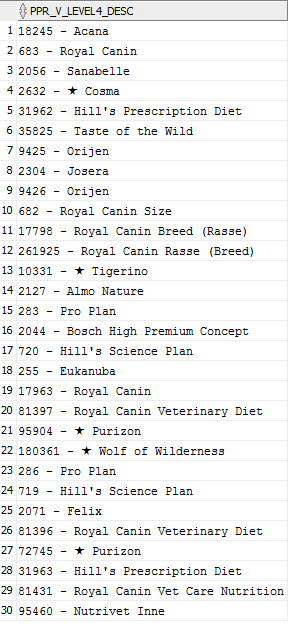

From the selected customers sample (114677 out of 161937 having 3 or more orders):

- Royal Canin Prods are Lead PG4s for 31% of the customers.
- Hill's Prods are Lead PG4s for 11.5% of the customers.
- Private label Prods are Lead PGs in 7.5% of the customers.
- Pro Plan Prods are Lead PG4s for 6% of the customers.
- Other brands with PGs acting as Lead PG4 for more than 2% of the customers:
  Eukanuba 3.18%, Orijen 2.24%, Taste of the wild 2.18%

#### Basket Analysis - apriori algorithm - 

In [139]:
data['PP_NAME'] = data['PP_NAME'].astype(str)

In [140]:
basket_info = list(data.groupby('SCM_N_ORDER_NR')['PP_NAME'].apply(list).values)

In [141]:
# Orders
len(basket_info)

875073

In [142]:
basket_info = [[item for item in basket if item != 'nan'] for basket in basket_info]

In [144]:
len(basket_info)

875073

In [145]:
import apriori_py3

In [153]:
L,suppData = apriori_py3.apriori(basket_info, minSupport = 0.001)

In [154]:
L

[[frozenset({'toothbrush holder zooplus'}),
  frozenset({'Wolf of Wilderness The Taste of Canada'}),
  frozenset({'Wolf of Wilderness The Taste of Scandinavia'}),
  frozenset({'Purizon Cat Sterilised Huhn & Fisch'}),
  frozenset({'Purizon Cat Wildschwein'}),
  frozenset({'RC MP wet cat food entry pack 4x85g pouches'}),
  frozenset({'Megapack Wild Freedom Dose 6 x 200 g'}),
  frozenset({'Xmas metal can'}),
  frozenset({'Wild Freedom - Cold River Lachs'}),
  frozenset({'Wild Freedom – Wide Country Geflügel'}),
  frozenset({'Wild Freedom - Wild Hills Ente'}),
  frozenset({'Wild Freedom - Green Lands Lamm'}),
  frozenset({'Kratzmöbel Circle'}),
  frozenset({'Kuscheldecke Welttierschutztag'}),
  frozenset({'Eukanuba blanket'}),
  frozenset({'Xmas blanket'}),
  frozenset({'Cosma Adventskalender für Katze'}),
  frozenset({'Tigerino Canada White Rose'}),
  frozenset({'zoolove Kotbeutel dreifarbig'}),
  frozenset({'Katzenspielzeug-Set Moppi mit Katzenminze'}),
  frozenset({'MP Schesir Cat Jelly

In [155]:
rules= apriori_py3.generateRules(L,suppData, minConf=0.10)

frozenset({'Wild Freedom – Wide Country Geflügel'}) --> frozenset({'Wild Freedom - Green Lands Lamm'}) conf: 0.43606998654104984
frozenset({'Wild Freedom - Green Lands Lamm'}) --> frozenset({'Wild Freedom – Wide Country Geflügel'}) conf: 0.8788426763110309
frozenset({'Wild Freedom - Wild Hills Ente'}) --> frozenset({'Wild Freedom – Wide Country Geflügel'}) conf: 0.7933823529411764
frozenset({'Wild Freedom – Wide Country Geflügel'}) --> frozenset({'Wild Freedom - Wild Hills Ente'}) conf: 0.4840735755944369
frozenset({'Wild Freedom - Cold River Lachs'}) --> frozenset({'Wild Freedom - Green Lands Lamm'}) conf: 0.6249149081007489
frozenset({'Wild Freedom - Green Lands Lamm'}) --> frozenset({'Wild Freedom - Cold River Lachs'}) conf: 0.8300180831826403
frozenset({'Wild Freedom - Cold River Lachs'}) --> frozenset({'Wild Freedom - Wild Hills Ente'}) conf: 0.6453369639210348
frozenset({'Wild Freedom - Wild Hills Ente'}) --> frozenset({'Wild Freedom - Cold River Lachs'}) conf: 0.6970588235294118